***Map-Reduce Program***

In [1]:
import csv
from collections import defaultdict

# Mapper function
def mapper(data):
    payment_method_counts = []
    for row in data:
        # Extract the payment method (column 7 in the dataset)
        payment_method = row[6]
        payment_method_counts.append((payment_method, 1))
    return payment_method_counts

# Reducer function
def reducer(mapped_data):
    reduced_data = defaultdict(int)
    for key, value in mapped_data:
        reduced_data[key] += value
    return reduced_data

# Load dataset function
def load_dataset(file_path):
    data = []
    with open(file_path, mode="r") as file:
        reader = csv.reader(file)
        header = next(reader)  # Skip the header row
        for row in reader:
            data.append(row)
    return data

# Main function to execute MapReduce
def main():
    # Load the dataset
    dataset_path = "Retail.csv"  # Ensure this file is in the same directory
    data = load_dataset(dataset_path)

    # Map step
    mapped_data = mapper(data)

    # Reduce step
    reduced_data = reducer(mapped_data)

    # Print the results
    print("Payment Method Counts:")
    for payment_method, count in reduced_data.items():
        print(f"{payment_method}: {count}")

if __name__ == "__main__":
    main()


Payment Method Counts:
Mobile Payment: 249711
Cash: 250230
Credit Card: 249985
Debit Card: 250074


***Apache Spark job:***

In [25]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, sum, avg, when


# Step 1: Initialize Spark Session
spark = SparkSession.builder \
    .appName("Retail Data Analysis with Plots") \
    .getOrCreate()

# Step 2: Load the Dataset
data_path = "Retail.csv"  # Update with the actual file path if needed
retail_df = spark.read.csv(data_path, header=True, inferSchema=True)

In [26]:
# Step 3: Show the Schema and Preview the Data
print("Dataset Schema:")
retail_df.printSchema()

print("\nSample Data:")
retail_df.show(5)

Dataset Schema:
root
 |-- Transaction_ID: integer (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Customer_Name: string (nullable = true)
 |-- Product: string (nullable = true)
 |-- Total_Items: integer (nullable = true)
 |-- Total_Cost: double (nullable = true)
 |-- Payment_Method: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Store_Type: string (nullable = true)
 |-- Discount_Applied: boolean (nullable = true)
 |-- Customer_Category: string (nullable = true)
 |-- Season: string (nullable = true)
 |-- Promotion: string (nullable = true)


Sample Data:
+--------------+-------------------+-----------------+--------------------+-----------+----------+--------------+-------------+----------------+----------------+-----------------+------+--------------------+
|Transaction_ID|               Date|    Customer_Name|             Product|Total_Items|Total_Cost|Payment_Method|         City|      Store_Type|Discount_Applied|Customer_Category|Season|           Pr

In [27]:
# Step 4: Data Cleaning and Filtering
# Check for missing values in each column
missing_values_df = retail_df.select([count(when(col(c).isNull(), c)).alias(c) for c in retail_df.columns])

# Show the number of missing values in each column
missing_values_df.show()

# Remove rows with null values in key columns
cleaned_df = retail_df.na.drop(subset=["Total_Items", "Total_Cost", "Payment_Method", "City"])
print(f"\nCleaned Data Count: {cleaned_df.count()}")

# Filter transactions where the total cost is greater than 50
filtered_df = cleaned_df.filter(col("Total_Cost") > 50)
print(f"Filtered Data Count (Total_Cost > 50): {filtered_df.count()}")


+--------------+----+-------------+-------+-----------+----------+--------------+----+----------+----------------+-----------------+------+---------+
|Transaction_ID|Date|Customer_Name|Product|Total_Items|Total_Cost|Payment_Method|City|Store_Type|Discount_Applied|Customer_Category|Season|Promotion|
+--------------+----+-------------+-------+-----------+----------+--------------+----+----------+----------------+-----------------+------+---------+
|             0|   0|            0|      0|          0|         0|             0|   0|         0|               0|                0|     0|        0|
+--------------+----+-------------+-------+-----------+----------+--------------+----+----------+----------------+-----------------+------+---------+


Cleaned Data Count: 1000000
Filtered Data Count (Total_Cost > 50): 525546


In [28]:
# Step 5: Data Aggregation
# Count of transactions by Payment Method
payment_counts = cleaned_df.groupBy("Payment_Method").count()
payment_counts_pandas = payment_counts.toPandas()
print("\nTransaction Counts by Payment Method:")
print(payment_counts_pandas)

# Total revenue by City
city_revenue = cleaned_df.groupBy("City").agg(sum("Total_Cost").alias("Total_Revenue"))
city_revenue_pandas = city_revenue.toPandas()
print("\nTotal Revenue by City:")
print(city_revenue_pandas)

# Average number of items per transaction by Season
avg_items_per_season = cleaned_df.groupBy("Season").agg(avg("Total_Items").alias("Avg_Items"))
avg_items_per_season_pandas = avg_items_per_season.toPandas()
print("\nAverage Number of Items per Transaction by Season:")
print(avg_items_per_season_pandas)


Transaction Counts by Payment Method:
   Payment_Method   count
0  Mobile Payment  249711
1     Credit Card  249985
2            Cash  250230
3      Debit Card  250074

Total Revenue by City:
            City  Total_Revenue
0         Dallas     5277111.53
1    Los Angeles     5232393.19
2  San Francisco     5241099.86
3        Chicago     5263187.45
4        Atlanta     5202731.84
5        Seattle     5235365.43
6        Houston     5247054.78
7          Miami     5240498.44
8       New York     5252469.92
9         Boston     5263307.96

Average Number of Items per Transaction by Season:
   Season  Avg_Items
0  Spring   5.500240
1  Summer   5.501308
2    Fall   5.492883
3  Winter   5.489332


In [29]:
# Step 6: Exploratory Data Analysis (EDA)
# Top 5 cities by total revenue
top_cities = city_revenue.orderBy(col("Total_Revenue").desc()).limit(5)
top_cities_pandas = top_cities.toPandas()
print("\nTop 5 Cities by Total Revenue:")
print(top_cities_pandas)

# Transaction count by Customer Category
customer_category_counts = cleaned_df.groupBy("Customer_Category").count()
customer_category_pandas = customer_category_counts.toPandas()
print("\nTransaction Counts by Customer Category:")
print(customer_category_pandas)

# Distribution of Discounts Applied
discount_distribution = cleaned_df.groupBy("Discount_Applied").count()
discount_distribution_pandas = discount_distribution.toPandas()
print("\nDiscount Distribution:")
print(discount_distribution_pandas)



Top 5 Cities by Total Revenue:
       City  Total_Revenue
0    Dallas     5277111.53
1    Boston     5263307.96
2   Chicago     5263187.45
3  New York     5252469.92
4   Houston     5247054.78

Transaction Counts by Customer Category:
  Customer_Category   count
0          Teenager  125319
1           Student  124842
2           Retiree  125072
3         Homemaker  125418
4    Senior Citizen  125485
5       Young Adult  124577
6      Professional  124651
7       Middle-Aged  124636

Discount Distribution:
   Discount_Applied   count
0              True  500104
1             False  499896


***Advanced Analytics and Machine Learning***

In [30]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt



In [31]:
# 2.2 Encode the target variable (Discount_Applied: TRUE -> 1, FALSE -> 0)
retail_df = retail_df.withColumn("Discount_Applied", when(col("Discount_Applied") == "TRUE", 1).otherwise(0))

# 2.3 Encode categorical features (Payment_Method)
indexer = StringIndexer(inputCol="Payment_Method", outputCol="Payment_Method_Index")
retail_df = indexer.fit(retail_df).transform(retail_df)

# 2.4 Assemble features into a single vector
feature_cols = ["Total_Items", "Total_Cost", "Payment_Method_Index"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
retail_df = assembler.transform(retail_df)

# Show the resulting DataFrame with new features
retail_df.select("Discount_Applied", "Payment_Method_Index", "features").show()

+----------------+--------------------+----------------+
|Discount_Applied|Payment_Method_Index|        features|
+----------------+--------------------+----------------+
|               1|                 3.0| [3.0,71.65,3.0]|
|               1|                 0.0| [2.0,25.93,0.0]|
|               1|                 2.0| [6.0,41.49,2.0]|
|               1|                 3.0| [1.0,39.34,3.0]|
|               0|                 1.0|[10.0,16.42,1.0]|
|               1|                 0.0| [3.0,72.24,0.0]|
|               0|                 0.0|  [4.0,5.28,0.0]|
|               0|                 1.0| [5.0,21.77,1.0]|
|               0|                 3.0| [4.0,55.25,3.0]|
|               1|                 3.0| [7.0,31.21,3.0]|
|               1|                 1.0| [8.0,91.59,1.0]|
|               0|                 3.0| [7.0,31.88,3.0]|
|               0|                 1.0| [9.0,39.75,1.0]|
|               0|                 3.0| [7.0,17.51,3.0]|
|               1|             

In [32]:
# Step 3: Split Data into Training and Testing Sets
train_data, test_data = retail_df.randomSplit([0.8, 0.2], seed=42)

# Step 4: Train the Model
lr = LogisticRegression(featuresCol="features", labelCol="Discount_Applied", maxIter=10)
lr_model = lr.fit(train_data)

ROC-AUC Score: 0.49888837963321214
Accuracy: 0.49997501199424277


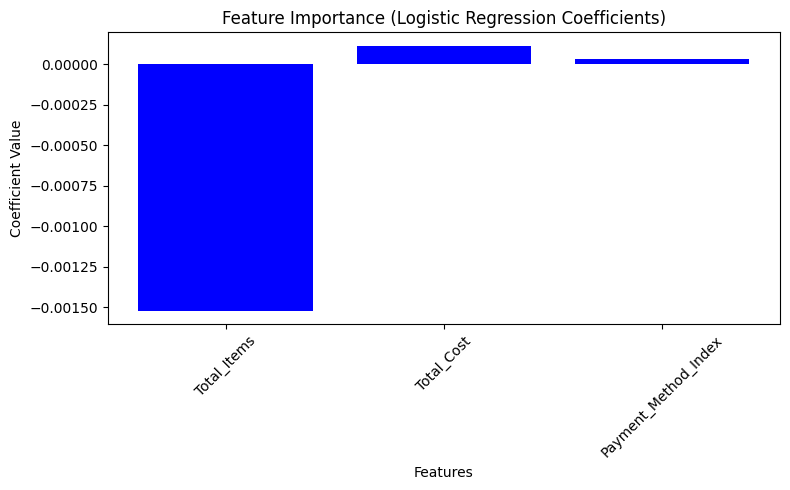

In [33]:
# Step 5: Evaluate the Model
# 5.1 Predictions
predictions = lr_model.transform(test_data)

# 5.2 Binary Classification Evaluator
evaluator = BinaryClassificationEvaluator(labelCol="Discount_Applied", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
roc_auc = evaluator.evaluate(predictions)
print(f"ROC-AUC Score: {roc_auc}")

# 5.3 Display Accuracy
accuracy = predictions.filter(predictions["Discount_Applied"] == predictions["prediction"]).count() / float(test_data.count())
print(f"Accuracy: {accuracy}")

# Step 6: Visualize Feature Coefficients
coefficients = lr_model.coefficients.toArray()
feature_importance = {col: coef for col, coef in zip(feature_cols, coefficients)}

# Plot Feature Coefficients
plt.figure(figsize=(8, 5))
plt.bar(feature_importance.keys(), feature_importance.values(), color='blue')
plt.title("Feature Importance (Logistic Regression Coefficients)")
plt.xlabel("Features")
plt.ylabel("Coefficient Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Step 7: Stop the Spark Session
spark.stop()